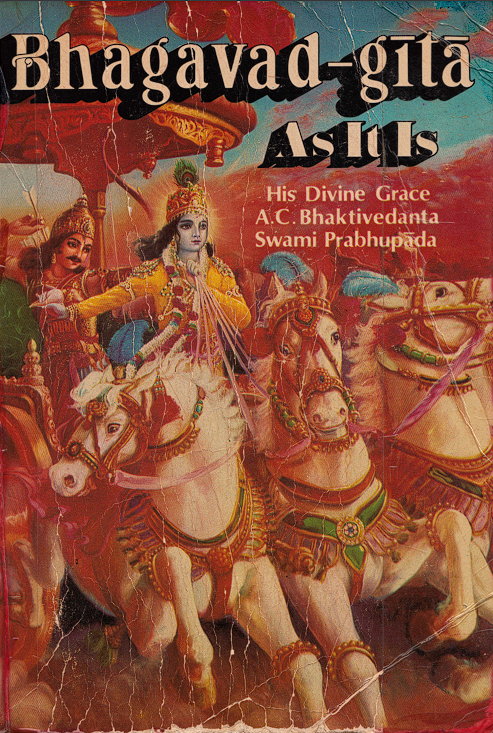

- Step1: Initialize the chroma db connection
- Step2: Create a Retriever Object
- Step3: Initialize a Chat Prompt Template
- Step4: Initialize a Generator(Chat Model)
- Step5: Initialize an Output Parser
- Step6: Define a RAG Chain
- Step7: Invoke the chain

### Before we initialize the chroma db connection, lets load the data first

In [1]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader('geeta.pdf')
data = loader.load()

In [3]:
data_content = [doc.page_content for doc in data]

In [4]:
data_content

['',
 'This\tfree\tfor\tdownload\tebook\tis\ta\tdirect\treproduction\tof\tthe\noriginal\tbona\tfide\tpersonally\tapproved\tand\tblessed\tby\tSrila\nPrabhupada.\nThis\tebook\twas\tmade\tby\tthe\tofficial\twebsite\tfor\tSrila\nPrabhupada’s\toriginal\tbooks:\nKrishnapath.org\nAll\tthe\tcontent\twas\tdirectly\ttaken\tfrom\tthe\toriginal\tscans,\tis\nunchanged\tand\tintact.\nMore\tfree\tdownloads\tat:\nwww.krishnapath.org',
 'Bhagavad-gītā \nAs\tIt\tIs',
 'Bhagavad-gītā\t\nAs\tIt\tIs\nCOMPLETE\tEDITION\nwith\toriginal\tSanskrit\ttext,\nRoman\ttransliteration,\tEnglish\tequivalents,\ntranslation\tand\telaborate\tpurports\nHis\tDivine\tGrace\nA.C.\tBhaktivedanta\tSwami\tPrabhupāda\nFounder-Ācārya\tof\tthe\tInternational\tSociety\tfor\tKrishna\tConsciousness\nCollier\tBooks,\tNew\tYork\nCollier\tMacmillan\tPublishers,\tLondon',
 'Copyright\t©\t1972\tby\tHis\tDivine\tGrace\nA.C.\tBhaktivedanta\tSwami\tPrabhupāda\nReaders\tinterested\tin\tthe\tsubject\tmatter\tof\tthis\nbook\tare\tinvited\tby\tt

### After that we'll do cleaning, chunking, embedding

In [5]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = list(set(stopwords.words('english')))
lemmatize = WordNetLemmatizer()

In [7]:
def clean(doc):
    docs = re.sub(r'www\.[^S]+', '', doc)
    docs = re.sub('[^A-Za-z]', ' ', doc)
    docs = ''.join([doc for doc in docs if doc not in string.punctuation])
    docs_token = nltk.word_tokenize(docs)
    docs_stop = [doc for doc in docs_token if doc not in stop_words]
    docs_lemma = [lemmatize.lemmatize(doc) for doc in docs_stop]
    return ' '.join(docs_lemma)

In [8]:
data_content = [clean(doc) for doc in data_content]

In [9]:
data_content

['',
 'This free download ebook direct reproduction original bona fide personally approved blessed Srila Prabhupada This ebook made official website Srila Prabhupada original book Krishnapath org All content directly taken original scan unchanged intact More free downloads www krishnapath org',
 'Bhagavad g As It Is',
 'Bhagavad g As It Is COMPLETE EDITION original Sanskrit text Roman transliteration English equivalent translation elaborate purport His Divine Grace A C Bhaktivedanta Swami Prabhup da Founder c rya International Society Krishna Consciousness Collier Books New York Collier Macmillan Publishers London',
 'Copyright His Divine Grace A C Bhaktivedanta Swami Prabhup da Readers interested subject matter book invited International Society Krishna Consciousness correspond Secretary International Society Krishna Consciousness Watseka Avenue Los Angeles California Library Congress Catalog Card Number All right reserved No part book may reproduced transmitted form mean electronic m

In [10]:
meta_data = [doc.metadata for doc in data]

In [12]:
len(meta_data)

892

In [13]:
len(data_content)

892

In [16]:
data_fin = []
for i in range(len(meta_data)):
    data_fin.append({'metadata' : meta_data[i],
                'content' : data_content[i]})

In [17]:
data_fin

[{'metadata': {'source': 'geeta.pdf', 'page': 0}, 'content': ''},
 {'metadata': {'source': 'geeta.pdf', 'page': 1},
  'content': 'This free download ebook direct reproduction original bona fide personally approved blessed Srila Prabhupada This ebook made official website Srila Prabhupada original book Krishnapath org All content directly taken original scan unchanged intact More free downloads www krishnapath org'},
 {'metadata': {'source': 'geeta.pdf', 'page': 2},
  'content': 'Bhagavad g As It Is'},
 {'metadata': {'source': 'geeta.pdf', 'page': 3},
  'content': 'Bhagavad g As It Is COMPLETE EDITION original Sanskrit text Roman transliteration English equivalent translation elaborate purport His Divine Grace A C Bhaktivedanta Swami Prabhup da Founder c rya International Society Krishna Consciousness Collier Books New York Collier Macmillan Publishers London'},
 {'metadata': {'source': 'geeta.pdf', 'page': 4},
  'content': 'Copyright His Divine Grace A C Bhaktivedanta Swami Prabhup da 

In [18]:
## Chunking

In [21]:
from langchain.schema import Document
documents = [Document(page_content=item['content'], metadata=item['metadata']) for item in data_fin]

In [22]:
documents

[Document(metadata={'source': 'geeta.pdf', 'page': 0}, page_content=''),
 Document(metadata={'source': 'geeta.pdf', 'page': 1}, page_content='This free download ebook direct reproduction original bona fide personally approved blessed Srila Prabhupada This ebook made official website Srila Prabhupada original book Krishnapath org All content directly taken original scan unchanged intact More free downloads www krishnapath org'),
 Document(metadata={'source': 'geeta.pdf', 'page': 2}, page_content='Bhagavad g As It Is'),
 Document(metadata={'source': 'geeta.pdf', 'page': 3}, page_content='Bhagavad g As It Is COMPLETE EDITION original Sanskrit text Roman transliteration English equivalent translation elaborate purport His Divine Grace A C Bhaktivedanta Swami Prabhup da Founder c rya International Society Krishna Consciousness Collier Books New York Collier Macmillan Publishers London'),
 Document(metadata={'source': 'geeta.pdf', 'page': 4}, page_content='Copyright His Divine Grace A C Bhak

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(separators = ['\n\n', '\n', ' ', ''],
                                               chunk_size = 150,
                                               chunk_overlap = 65)
chunks = text_splitter.split_documents(documents)                                          

In [25]:
chunks[:3]

[Document(metadata={'source': 'geeta.pdf', 'page': 1}, page_content='This free download ebook direct reproduction original bona fide personally approved blessed Srila Prabhupada This ebook made official website Srila'),
 Document(metadata={'source': 'geeta.pdf', 'page': 1}, page_content='blessed Srila Prabhupada This ebook made official website Srila Prabhupada original book Krishnapath org All content directly taken original scan'),
 Document(metadata={'source': 'geeta.pdf', 'page': 1}, page_content='book Krishnapath org All content directly taken original scan unchanged intact More free downloads www krishnapath org')]

In [26]:
## EMbedding

In [27]:
from langchain_huggingface import HuggingFaceEmbeddings

In [32]:
hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [37]:
#!pip install --upgrade transformers tokenizers

# Step 1: Initialize the Chroma DB connection

### Lets initalize our vector db

In [34]:
from langchain.vectorstores import Chroma

db = Chroma(collection_name = 'vect-db',
            embedding_function = hf_embeddings,
            persist_directory = 'chroma_db')

db.get()

C:\Users\DeLL\AppData\Local\Temp\ipykernel_16208\3507137183.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(collection_name = 'vect-db',


{'ids': [],
 'embeddings': None,
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [36]:
db.add_documents(chunks)

['50dd704b-f8cd-4b2e-bd57-37a016fc4b2c',
 '3accf2ca-0f49-4f23-91aa-3de691c69102',
 '68143603-03dc-41ff-a23a-f79e6d903abb',
 'fd4f7bc9-2989-4b48-b9b9-e00c475758a9',
 'da975beb-8384-48ee-b6a0-3b810b11d571',
 '56f892c0-de76-42d2-a919-369fa104b7cf',
 'acb1fe78-c048-4b19-9e06-3fbb7e5a5279',
 '033d1a01-607a-45f2-8750-93cde61e928c',
 '9794cc1f-84f2-4dae-a4b2-02a0e2f07240',
 'ddbf5672-542b-44df-ae01-7915db4f1d34',
 '4b398791-7c51-4d2e-9201-fc0b701d0ff7',
 'f34d318c-b93d-4346-a515-db1f49bdca92',
 '2ce274c4-2259-4d28-8959-3bb70f6af606',
 '0988213d-cd39-44a6-b607-46b1dfd4e72b',
 'f4c88f51-401d-4eaa-9bfc-3cdd81621d29',
 '7ebe6a33-b60c-4735-bc16-721e952e6219',
 '5164bc17-53e7-4074-9889-4f0ac0081b42',
 'a0a86ee9-f08a-4e5b-b62a-ec01ac1c1ff4',
 '6ab8793a-e1bd-474e-ab00-0c46b002de96',
 '0d8aaf08-a43c-4c14-9b88-05082f9c8edb',
 '25a56901-9c01-4c78-8f6b-e67b8d90e550',
 '738dc8ad-26e2-474a-a9a3-7f2885345ea0',
 '2af83df3-1d00-4914-91d6-4b14ecad9126',
 'cab7c035-6892-4f4f-affe-7c274316da63',
 '368794db-f20d-

In [38]:
db.get()

{'ids': ['50dd704b-f8cd-4b2e-bd57-37a016fc4b2c',
  '3accf2ca-0f49-4f23-91aa-3de691c69102',
  '68143603-03dc-41ff-a23a-f79e6d903abb',
  'fd4f7bc9-2989-4b48-b9b9-e00c475758a9',
  'da975beb-8384-48ee-b6a0-3b810b11d571',
  '56f892c0-de76-42d2-a919-369fa104b7cf',
  'acb1fe78-c048-4b19-9e06-3fbb7e5a5279',
  '033d1a01-607a-45f2-8750-93cde61e928c',
  '9794cc1f-84f2-4dae-a4b2-02a0e2f07240',
  'ddbf5672-542b-44df-ae01-7915db4f1d34',
  '4b398791-7c51-4d2e-9201-fc0b701d0ff7',
  'f34d318c-b93d-4346-a515-db1f49bdca92',
  '2ce274c4-2259-4d28-8959-3bb70f6af606',
  '0988213d-cd39-44a6-b607-46b1dfd4e72b',
  'f4c88f51-401d-4eaa-9bfc-3cdd81621d29',
  '7ebe6a33-b60c-4735-bc16-721e952e6219',
  '5164bc17-53e7-4074-9889-4f0ac0081b42',
  'a0a86ee9-f08a-4e5b-b62a-ec01ac1c1ff4',
  '6ab8793a-e1bd-474e-ab00-0c46b002de96',
  '0d8aaf08-a43c-4c14-9b88-05082f9c8edb',
  '25a56901-9c01-4c78-8f6b-e67b8d90e550',
  '738dc8ad-26e2-474a-a9a3-7f2885345ea0',
  '2af83df3-1d00-4914-91d6-4b14ecad9126',
  'cab7c035-6892-4f4f-affe-

In [39]:
print(len(db.get()["ids"]))

12086


# Step 2: Create a retriever object

In [42]:
retriever = db.as_retriever(search_type = 'similarity', search_kwargs = {'k':5})

# Step 3: Initialize a Chat Prompt Template

In [54]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = '''
Answer the question based on the following context:
{context}
Answer the question based on the above context: {question}
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
please also dont mention that the provided text is saying that.
just give the response.
Do not say "according to the context" or "mentioned in the context" or similar.
'''
prompt_temp = ChatPromptTemplate.from_template(prompt_template)

# Step 4: Initialize a Generator (Chat Model)

In [46]:
from langchain_google_genai import ChatGoogleGenerativeAI

with open(r"C:\Users\DeLL\Documents\Data Science\Gen AI\Building  conversational chat bot and intro to Gemini\Google API Key.txt") as f:
    key = f.read()
    
chat_model = ChatGoogleGenerativeAI(api_key = key, model = 'gemini-1.5-flash')

# Step 5: Initialize a Output Parser

In [47]:
from langchain_core.output_parsers import StrOutputParser
output_parser = StrOutputParser()

# Step 6: Build a RAG chain

In [48]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)
    
chain = {'context' : retriever | format_docs, 'question' : RunnablePassthrough()} | prompt_temp | chat_model | output_parser

# Step 7: Invoke the chain

In [56]:
# Invoke the Chain

query = 'What did krishan said to arjun?'

chain.invoke(query)

'Krishna told Arjuna to fight.  He said that Arjuna\'s concern was only with the outcome of the fight, and that Arjuna should simply act according to Krishna\'s dictation.  Krishna also said, "Govinda, I shall fight," after Arjuna chastised his enemies and fell silent.'

In [55]:
# Invoke the Chain

query = 'What did yudishtra did?'

chain.invoke(query)

"The provided text states that Yudhishthira's victory was certain because Arjuna was fighting on his behalf.  The battle would decide who would rule the world, and Yudhishthira's victory was predicted.  He was also predicted to flourish as a righteous, pious, and strict moralist."

In [59]:
query = 'What is the mother of arjuna?'

chain.invoke(query)

'Pritha.'

In [58]:
query = 'What is the mother of nakul?'

chain.invoke(query)

'The provided text states that Nakula is the son of Kuntī.'

In [60]:
query = 'What was happened to draupadi?'

chain.invoke(query)

'Draupadi, the wife of Arjuna and daughter of King Drupada, was forced to be stripped naked in the presence of a great general assembly.  She was in a helpless condition and appealed for justice.'

In [62]:
query = 'What is the plan of brahma?'

chain.invoke(query)

"Brahma's plan involves always being engaged in the spiritual world of the Supreme Personality Godhead.  After liberation and achieving the Brahman position, one begins devotional service to understand the Supreme.  Brahma's abode is the ultimate destination."

In [63]:
query = 'how can we achieve peace?'

chain.invoke(query)

'The greatest peace formula is simply Lord K.  Those seeking peace in different ways, and who want to achieve real happiness, should consult the Kṛṣṇa Bhagavad-gītā and Śrīmad-Bhāgavatam.  Peace is culminated in knowledge of Kṛṣṇa.  One who enjoys peace within needs not search for peace elsewhere.'

In [64]:
query = 'what was Dhrtarastra thinking?'

chain.invoke(query)

'Dhritarashtra was hopeful for victory for his son, assisted by a great warrior like Bhishma.  He hoped for victory.'

In [71]:
print(chat_model.invoke(query))

content="Dhritarashtra's thoughts and motivations are complex and multifaceted, and interpretations vary depending on the source and the lens through which he's viewed.  There's no single definitive answer, but we can explore some likely elements:\n\n* **Blindness as a metaphor:** His physical blindness is often interpreted as a metaphor for his blindness to truth, justice, and the consequences of his actions. He was unable or unwilling to see the flaws in his own character and the destructive path he was leading his sons down.\n\n* **Love for his sons, but flawed:** Dhritarashtra deeply loved his sons, the Kauravas, even though they were often cruel and unjust. This love was blind and unconditional, preventing him from objectively assessing their character or holding them accountable for their actions.  His love was more of an attachment that blinded him to their flaws, making him complicit in their misdeeds.\n\n* **Fear of losing power:**  Dhritarashtra was deeply concerned about mai